WORD2VEC 3.0

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import nltk
nltk.download("popular")

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Modules for data manipulation
import numpy as np
import pandas as pd
import re
import string

# Modules for visualization
import matplotlib.pyplot as plt
import seaborn as sb

# Tools for preprocessing input data
from bs4 import BeautifulSoup
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

# Tools for creating ngrams and vectorizing input data
from gensim.models import Word2Vec
from gensim.models.phrases import Phrases, Phraser


# Tools for building a model
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Bidirectional, SpatialDropout1D
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.initializers import Constant
from keras.optimizers import Adam

# Tools for assessing the quality of model prediction
from sklearn.metrics import accuracy_score, confusion_matrix

from tqdm import tqdm

In [6]:
import pandas as pd
tweet_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Dataset/train.csv", encoding = "ISO-8859-1", error_bad_lines=False)    
tweet_test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Dataset/test.csv", encoding = "ISO-8859-1", error_bad_lines=False)

# Concatenate train test data for cleaning.
df=pd.concat([tweet_train,tweet_test])
print(df.shape)

(10876, 5)


In [7]:
df.target.unique()
# CHECK CLASS BALANCE
print(df['target'].value_counts())
print(df.target.unique())

0.0    4342
1.0    3271
Name: target, dtype: int64
[ 1.  0. nan]


In [8]:
df.dropna(subset=['text'])
print(df['target'].value_counts())

0.0    4342
1.0    3271
Name: target, dtype: int64


In [9]:
all_Text = np.array([], dtype=str)
all_Text = np.concatenate((all_Text, df.text), axis=0)
print('Total number of reviews:', len(all_Text))
print(all_Text[:10])

Total number of reviews: 10876
['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'
 'Forest fire near La Ronge Sask. Canada'
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"
 '13,000 people receive #wildfires evacuation orders in California '
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school '
 '#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires'
 '#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas'
 "I'm on top of the hill and I can see a fire in the woods..."
 "There's an emergency evacuation happening now in the building across the street"
 "I'm afraid that the tornado is coming to our area..."]


In [10]:
def get_length(sentence):
  return len(sentence.split())
  
df['word_length'] = df['text'].map(lambda x : get_length(x))
median = df['word_length'].median()
mean = df['word_length'].mean()
mode = df['word_length'].mode()[0]

In [11]:
import numpy as np
df['text_length'] = np.array(list(map(len, all_Text)))
median_tl = df['text_length'].median()
mean_tl = df['text_length'].mean()
mode_tl = df['text_length'].mode()[0]



fig, ax = plt.subplots()
sb.distplot(df['text_lenght'], bins=df['text_lenght'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(df['text_lenght'], 95))
ax.set_xlabel('Words in Requirements')
ymax = 0.014
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per Requirements distribution', fontsize=20)
plt.legend()
plt.show()



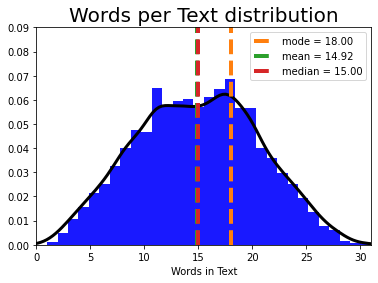

In [13]:
fig, ax = plt.subplots()
sb.distplot(df['word_length'], bins=df['word_length'].max(),
            hist_kws={"alpha": 0.9, "color": "blue"}, ax=ax,
            kde_kws={"color": "black", 'linewidth': 3})
ax.set_xlim(left=0, right=np.percentile(df['word_length'], 100))
ax.set_xlabel('Words in Text')
ymax = 0.09
plt.ylim(0, ymax)
ax.plot([mode, mode], [0, ymax], '--', label=f'mode = {mode:.2f}', linewidth=4)
ax.plot([mean, mean], [0, ymax], '--', label=f'mean = {mean:.2f}', linewidth=4)
ax.plot([median, median], [0, ymax], '--',
        label=f'median = {median:.2f}', linewidth=4)
ax.set_title('Words per Text distribution', fontsize=20)
plt.legend()
plt.show()


In [14]:
def clean_data(df, text_col, new_col='cleaned_text'):
    
    '''It will remove the noise from the text data(@user, characters not able to encode/decode properly)    
    Arguments:
    df : Data Frame
    col : column name of type string
    '''
    tweets_data = df.copy()
    
    #tweets_data[new_col] = tweets_data[text_col].apply(lambda x : re.sub(
    #   f"@[A-Za-z0-9]+", '', x))
    
    #temp line
    tweets_data[new_col] = tweets_data[text_col]
 

    # Keeping only few punctuations 
    tweets_data[new_col] = tweets_data[new_col].apply(lambda x : re.sub(
        '@[A-Za-z0-9]+', '', x))

    #tweets_data[new_col] = tweets_data[new_col].apply(lambda x : re.sub(
        #f'[^{PUNCTUATION_TO_KEEP}A-Za-z0-9]', '', x))

    # Trimming the sentences
    tweets_data[new_col] = tweets_data[new_col].str.strip()
    
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub('\\n',' ',str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r'\W',' ',str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r'https\s+|www.\s+',r'', str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r'http\s+|www.\s+',r'', str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r'\s+[a-zA-Z]\s+',' ',str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r'\^[a-zA-Z]\s+',' ',str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r'\s+',' ',str(x)))
    tweets_data[new_col] = tweets_data[new_col].str.lower()
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\’", "\'", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"won\'t", "will not", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"can\'t", "can not", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"don\'t", "do not", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"dont", "do not", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"n\’t", " not", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"n\'t", " not", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\'re", " are", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\'s", " is", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\’d", " would", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\d", " would", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\'ll", " will", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\'t", " not", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\'ve", " have", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\'m", " am", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\n", "", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\r", "", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"[0-9]", "digit", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\'", "", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r"\"", "", str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r'[?|!|\'|"|#]',r'', str(x)))
    tweets_data[new_col] = tweets_data[new_col].map(lambda x: re.sub(r'[.|,|)|(|\|/]',r' ', str(x)))
    
    return tweets_data
  
df = clean_data(df, "text", 'cleaned_text')
df.head()

,id,keyword,location,text,target,word_length,text_length,cleaned_text
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1.0,13,69,our deeds are the reason of this earthquake ma...
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1.0,7,38,forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1.0,22,133,all residents asked to shelter in place are be...
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1.0,8,65,would would would would would people receive...
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1.0,16,88,just got sent this photo from ruby alaska as s...


In [15]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stop_words = set(stopwords.words("english")) 
lemmatizer = WordNetLemmatizer()


def preprocess(text: str, total: int, show_progress: bool = True) -> list:
    if show_progress:
        global counter
        counter += 1
        print('Processing... %6i/%6i'% (counter, total), end='\r')
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    #text = text.split('note:')[0]
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = list(filter(None, text))
    #text = " ".join(text)
    return text

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = text.lower()
    text = text.split('note:')[0]
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = [word for word in text if not word in stop_words]
    text = list(filter(None, text))
    #text = " ".join(text)
    return text

df['Processed_Text'] = df.cleaned_text.apply(lambda x: clean_text(x))
df[-10:]

,id,keyword,location,text,target,word_length,text_length,cleaned_text,Processed_Text
3253,10838,NaN,NaN,Malaysian PM confirms debris is from missing f...,NaN,10,80,malaysian pm confirms debris is from missing f...,"[malaysian, pm, confirm, debris, miss, flight,..."
3254,10845,NaN,NaN,Officials: Alabama home quarantined over possi...,NaN,11,79,officials alabama home quarantined over possib...,"[official, alabama, home, quarantine, possible..."
3255,10856,NaN,NaN,See the 16yr old PKK suicide bomber who detona...,NaN,21,138,see the would wouldyr old pkk suicide bomber ...,"[see, would, wouldyr, old, pkk, suicide, bombe..."
3256,10857,NaN,NaN,To conference attendees! The blue line from th...,NaN,24,129,to conference attendees the blue line from the...,"[conference, attendee, blue, line, airport, ha..."
3257,10858,NaN,NaN,The death toll in a #IS-suicide car bombing on...,NaN,27,136,the death toll in is suicide car bombing on yp...,"[death, toll, suicide, car, bomb, ypg, positio..."
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÂÃÃ SAFETY FA...,NaN,8,58,earthquake safety los angeles â ã ã safety fas...,"[earthquake, safety, los, angeles, â, ã, ã, sa..."
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...,NaN,23,139,storm in ri worse than last hurricane my city ...,"[storm, ri, worse, last, hurricane, city, amp,..."
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...,NaN,6,55,green line derailment in chicago co utbxlcbiuy,"[green, line, derailment, chicago, co, utbxlcb..."
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...,NaN,7,65,meg issues hazardous weather outlook hwo co w...,"[meg, issue, hazardous, weather, outlook, hwo,..."
3262,10875,NaN,NaN,#CityofCalgary has activated its Municipal Eme...,NaN,8,68,cityofcalgary has activated its municipal eme...,"[cityofcalgary, ha, activate, municipal, emerg..."


In [16]:
all_Text = np.array([], dtype=str)
all_Text = np.concatenate((all_Text, df.cleaned_text), axis=0)
print('Total number of reviews:', len(all_Text))
print(all_Text[:10])

Total number of reviews: 10876
['our deeds are the reason of this earthquake may allah forgive us all'
 'forest fire near la ronge sask canada'
 'all residents asked to shelter in place are being notified by officers no other evacuation or shelter in place orders are expected'
 ' would would  would would would people receive wildfires evacuation orders in california'
 'just got sent this photo from ruby alaska as smoke from wildfires pours into school'
 ' rockyfire update california hwy  would would closed in both directions due to lake county fire cafire wildfires'
 ' flood disaster heavy rain causes flash flooding of streets in manitou colorado springs areas'
 'i on top of the hill and can see fire in the woods '
 'there an emergency evacuation happening now in the building across the street'
 'i afraid that the tornado is coming to our area ']


In [17]:
counter = 0
all_Processed_Text = np.array(list(map(lambda x: preprocess(x, len(all_Text)), all_Text)))


In [19]:
corpus = all_Processed_Text

corpus[:20]

array([list(['deed', 'reason', 'earthquake', 'may', 'allah', 'forgive', 'u']),
       list(['forest', 'fire', 'near', 'la', 'ronge', 'sask', 'canada']),
       list(['resident', 'ask', 'shelter', 'place', 'notify', 'officer', 'evacuation', 'shelter', 'place', 'order', 'expect']),
       list(['would', 'would', 'would', 'would', 'would', 'people', 'receive', 'wildfire', 'evacuation', 'order', 'california']),
       list(['get', 'send', 'photo', 'ruby', 'alaska', 'smoke', 'wildfire', 'pour', 'school']),
       list(['rockyfire', 'update', 'california', 'hwy', 'would', 'would', 'close', 'direction', 'due', 'lake', 'county', 'fire', 'cafire', 'wildfire']),
       list(['flood', 'disaster', 'heavy', 'rain', 'cause', 'flash', 'flood', 'street', 'manitou', 'colorado', 'spring', 'area']),
       list(['top', 'hill', 'see', 'fire', 'wood']),
       list(['emergency', 'evacuation', 'happen', 'build', 'across', 'street']),
       list(['afraid', 'tornado', 'come', 'area']),
       list(['three', 

In [20]:
embedding_dict={}
with open('/content/drive/My Drive/Colab Notebooks/Dataset/glove.twitter.27B.200d.txt','r',encoding="utf8") as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')


word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,200))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 23818/23818 [00:00<00:00, 575865.14it/s]

Number of unique words: 23818


In [21]:
train=tweet_pad[:tweet_train.shape[0]]
test=tweet_pad[tweet_train.shape[0]:]
print(train.shape)
print(test.shape)

(7613, 50)
(3263, 50)


In [22]:
X_train,X_test,y_train,y_test=train_test_split(train,tweet_train['target'].values,test_size=0.2)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

Shape of train (6090, 50)
Shape of Validation  (1523, 50)


In [23]:
from sklearn.ensemble import RandomForestClassifier
#%% Model code - fitting the model
y_train = y_train.astype('bool')
y_test = y_test.astype('bool')
RF_classifier = RandomForestClassifier(bootstrap= False,
                                         max_depth= None,
                                         max_features= 'sqrt',
                                         min_samples_leaf= 1,
                                         min_samples_split= 2,
                                         n_estimators= 100
                                      )
RF_classifier.fit(X_train, y_train)

#%%
print('train accuracy:', RF_classifier.score(X_train,y_train))
print('test accuracy:', RF_classifier.score(X_test,y_test))

train accuracy: 0.9952380952380953
test accuracy: 0.6657912015758372


In [50]:
def build_model(embedding_matrix: np.ndarray, input_length: int): 
    model = Sequential()
    model.add(Embedding(
        input_dim = embedding_matrix.shape[0],
        output_dim = embedding_matrix.shape[1], 
        input_length = input_length,
        weights = [embedding_matrix],
        trainable=False))
    model.add(SpatialDropout1D(0.2))
    model.add(LSTM(128, recurrent_dropout=0.2, return_sequences = False))
    #model.add(Bidirectional(LSTM(32, recurrent_dropout=0.1)))
    #model.add(Dropout(0.25))
    #model.add(Dense(128, activation="sigmoid"))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    return model

model = build_model(
    embedding_matrix=embedding_matrix,
    input_length=MAX_LEN)
    

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 50, 200)           4763800   
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 50, 200)           0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               168448    
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 4,932,377
Trainable params: 168,577
Non-trainable params: 4,763,800
_________________________________________________________________


In [51]:
model.compile(
    loss="binary_crossentropy",
    optimizer='adam',
    metrics=['accuracy'])

history=model.fit(X_train,y_train,batch_size=32,epochs=6,validation_data=(X_test,y_test),verbose=2)


Epoch 1/6
191/191 - 16s - loss: 0.5357 - accuracy: 0.7489 - val_loss: 0.4710 - val_accuracy: 0.7912
Epoch 2/6
191/191 - 16s - loss: 0.4782 - accuracy: 0.7908 - val_loss: 0.4831 - val_accuracy: 0.7800
Epoch 3/6
191/191 - 16s - loss: 0.4562 - accuracy: 0.7985 - val_loss: 0.4645 - val_accuracy: 0.7997
Epoch 4/6
191/191 - 16s - loss: 0.4431 - accuracy: 0.8087 - val_loss: 0.4484 - val_accuracy: 0.8116
Epoch 5/6
191/191 - 16s - loss: 0.4272 - accuracy: 0.8123 - val_loss: 0.4618 - val_accuracy: 0.7965
Epoch 6/6
191/191 - 16s - loss: 0.4087 - accuracy: 0.8269 - val_loss: 0.4310 - val_accuracy: 0.8050


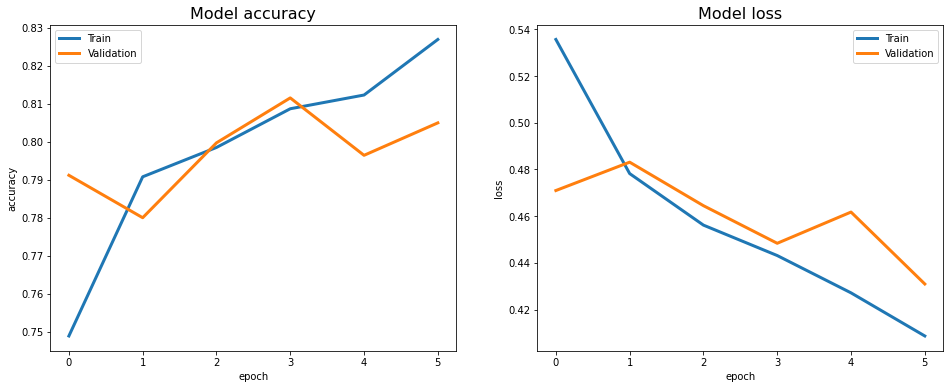

In [52]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train', linewidth=3)
axis1.plot(history.history['val_accuracy'], label='Validation', linewidth=3)
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train', linewidth=3)
axis2.plot(history.history['val_loss'], label='Validation', linewidth=3)
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

In [53]:

def plot_confusion_matrix(y_true, y_pred, ax, class_names, vmax=None,
                          normed=True, title='Confusion matrix'):
    matrix = confusion_matrix(y_true,y_pred)
    if normed:
        matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    sb.heatmap(matrix, vmax=vmax, annot=True, square=True, ax=ax,
               cmap=plt.cm.Blues_r, cbar=False, linecolor='black',
               linewidths=1, xticklabels=class_names)
    ax.set_title(title, y=1.20, fontsize=16)
    #ax.set_ylabel('True labels', fontsize=12)
    ax.set_xlabel('Predicted labels', y=1.10, fontsize=12)
    ax.set_yticklabels(class_names, rotation=0)

In [54]:
y_train_pred = model.predict_classes(X_train)
y_test_pred = model.predict_classes(X_test)

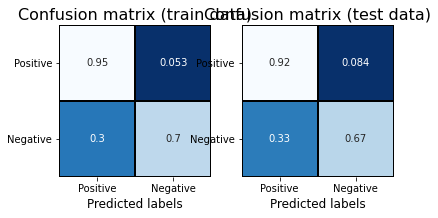

In [55]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2)
plot_confusion_matrix(y_train, y_train_pred, ax=axis1,
                      title='Confusion matrix (train data)',
                      class_names=['Positive', 'Negative'])
plot_confusion_matrix(y_test, y_test_pred, ax=axis2,
                      title='Confusion matrix (test data)',
                      class_names=['Positive', 'Negative'])

In [57]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)
sample_sub=pd.read_csv('/content/drive/My Drive/Colab Notebooks/Dataset/sample_submission.csv')
sub=pd.DataFrame({'id':sample_sub['id'].values.tolist(),'target':y_pre})
#sub.to_csv('/content/drive/My Drive/Colab Notebooks/Dataset/sample_submission_v4.csv',index=False)